# Can you estimate the age of an abalone?

## 📖 Background
You are working as an intern for an abalone farming operation in Japan. For operational and environmental reasons, it is an important consideration to estimate the age of the abalones when they go to market. 

Determining an abalone's age involves counting the number of rings in a cross-section of the shell through a microscope. Since this method is somewhat cumbersome and complex, you are interested in helping the farmers estimate the age of the abalone using its physical characteristics.

## 💾 The data
You have access to the following historical data ([source](https://archive.ics.uci.edu/ml/datasets/abalone)):

#### Abalone characteristics:
- "sex" - M, F, and I (infant).
- "length" - longest shell measurement.
- "diameter" - perpendicular to the length.
- "height" - measured with meat in the shell.
- "whole_wt" - whole abalone weight.
- "shucked_wt" - the weight of abalone meat.
- "viscera_wt" - gut-weight.
- "shell_wt" - the weight of the dried shell.
- "rings" - number of rings in a shell cross-section.
- "age" - the age of the abalone: the number of rings + 1.5.

***Acknowledgments**: Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn, and Wes B Ford (1994) "The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait", Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288).*

## 💪 Competition challenge
Create a report that covers the following:

1. How does weight change with age for each of the three sex categories?
2. Can you estimate an abalone's age using its physical characteristics? 
3. Investigate which variables are better predictors of age for abalones.

In [320]:
#!pip install xgboost

In [321]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import pickle
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [322]:
#load the dataset

df = pd.read_csv('abalone.csv')

df.head()

,sex,length,diameter,height,whole_wt,shucked_wt,viscera_wt,shell_wt,rings,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5


In [323]:
# Check the datatypes
df.dtypes

sex            object
length        float64
diameter      float64
height        float64
whole_wt      float64
shucked_wt    float64
viscera_wt    float64
shell_wt      float64
rings           int64
age           float64
dtype: object

#### Explore general statistics of the data

In [324]:


df.describe()

,length,diameter,height,whole_wt,shucked_wt,viscera_wt,shell_wt,rings,age
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684,11.433684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000,2.500000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000,9.500000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000,10.500000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000,12.500000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,30.500000


#### Ckeck for any missing data

In [325]:


df.isna().sum().sum()

0

There is no misssing data

### Distribution of Age

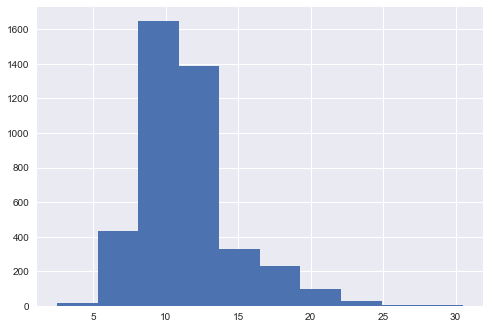

In [326]:


plt.style.use("seaborn")
df["age"].hist();

### Distribution of all numeric features

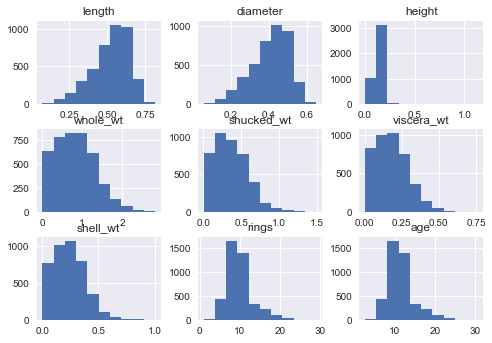

In [327]:


df.hist();

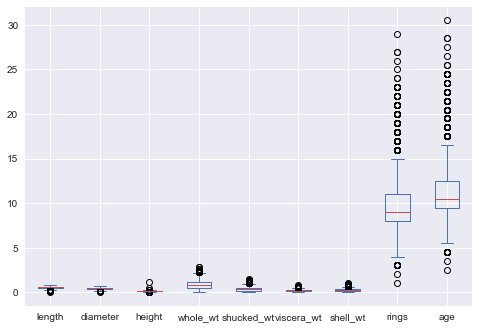

In [328]:
df.plot(kind="box");

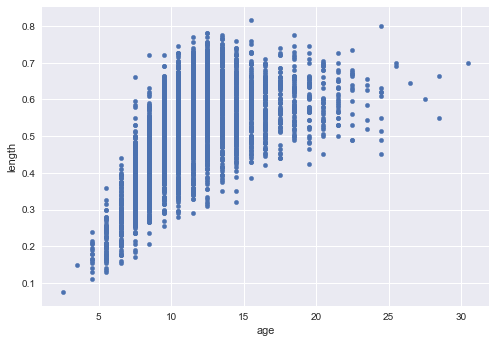

In [329]:
df.plot(kind="scatter", x='age', y='length');

There is a positive correlation between the age and lenght of an abalone.

### Relationship between age and diameter

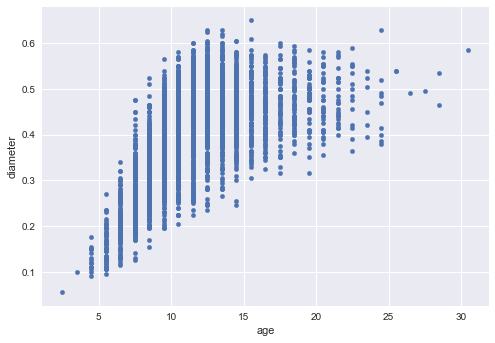

In [330]:


df.plot(kind="scatter", x='age', y='diameter');

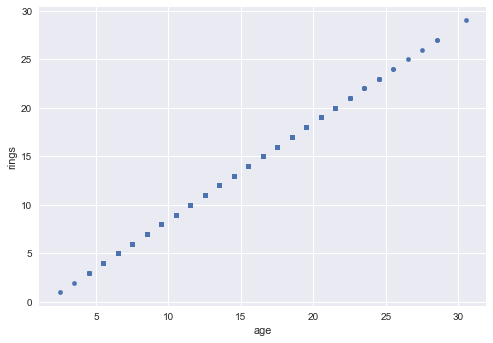

In [331]:
df.plot(kind="scatter", x='age', y='rings');

### How does weight change with age for each of the three sex categories?

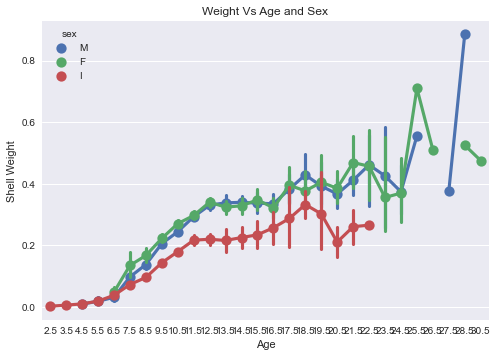

In [332]:
sb.pointplot(data=df, x="age", y="shell_wt", hue="sex");
plt.title("Weight Vs Age and Sex")
plt.ylabel("Shell Weight")
plt.xlabel("Age");

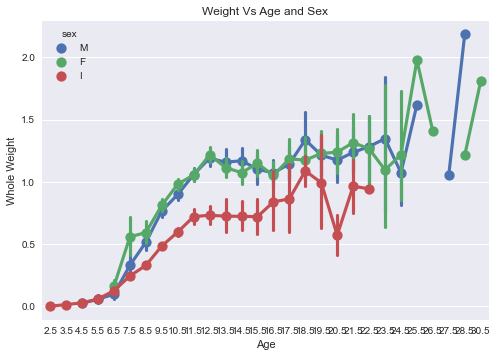

In [333]:
sb.pointplot(data=df, x="age", y="whole_wt", hue="sex");
plt.title("Weight Vs Age and Sex")
plt.ylabel("Whole Weight")
plt.xlabel("Age");

There is no significant difference between the **male** and **female** abalones. However, **infant** records lower weight.

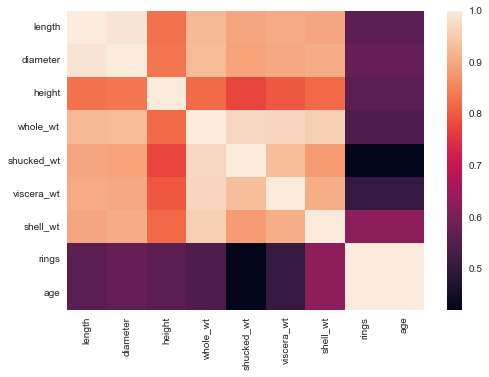

In [334]:
sb.heatmap(df.corr());

In [335]:
df.corr()["age"].sort_values()

shucked_wt    0.420884
viscera_wt    0.503819
whole_wt      0.540390
length        0.556720
height        0.557467
diameter      0.574660
shell_wt      0.627574
rings         1.000000
age           1.000000
Name: age, dtype: float64

Shell weight diameter have a high positive correlation with the age of an abalone. As an abalone ages, the weight increases.

## Split

In [336]:
def split(df, features = []):
    
    ''''
    Function to split the dataset
    
    Parameters:
    
    features: (list) - features to use in the prediction
    
    Returns:
    
    X_train: DataFrame - Training feature dataset
    X_test: DataFrame - Test feature dataset
    X_val: DataFrame - Validation feature dataset
    y_train: Series - Training target dataset
    y_test: Series - Testing target dataset
    y_val: Series - Validation target dataset
    '''
    # Convert categorical data to numeric representaion
    df = pd.get_dummies(df)
    
    # Drop age and rings features to prevent data leakage

    X = df.drop(columns=["age","rings"]) # Features
    y = df["age"] # Target
    
    # Subset features to the features provided
    if features:
        X = X[features]

    # Split the data into train and test set. We will use 80% of the data for training
    # and the remaining data for evaluation.

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, train_size=0.8, random_state=42, shuffle=True)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, train_size=0.8, random_state=42, shuffle=True)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [337]:
# Get the training and test sets
X_train, X_test,X_val, y_train, y_test, y_val  = split(df)

In [338]:
X_train.shape

(2672, 10)

In [339]:
y_train.shape

(2672,)

#  Build Model

##  Baseline

Set a baseline which we will use to evaluate our model's performance.

In [340]:
y_mean = y_train.mean()

 Create a list the same length as **y_train** to store the value of **y_mean**.

In [341]:
y_pred_baseline =  [y_mean] * len(y_train)

y_pred_baseline[:3]

[11.486152694610778, 11.486152694610778, 11.486152694610778]


Calculate the baseline mean absolute error for the predictions in **y_pred_baseline** as compared to the actual targets in **y_train**.

In [342]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 11.49
Baseline MAE: 2.37


Our next step is to build a model that beats the baseline model.

## Iterate

Scale the data for better prediction accuracy

In [343]:
scaler = MinMaxScaler(feature_range=(0,1))

features = X_train.columns

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

Initialize a **linear regression** model and fit it to the data.

In [344]:
model = LinearRegression(n_jobs=-1)

model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

## Evaluate

Evaluate the model on the training data.

In [345]:
y_pred_training = model.predict(X_train)

Calculate the mean absolute error for the predictions.

In [346]:

mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))


Training MAE: 1.58


The linear regression model is performing better than the baseline model. Perhaps a different model could do better.
Declare a model fitting function to test other models

In [347]:
def predict(model, X_val,y_val):
    model.fit(X_train, y_train,
             eval_set=[(X_val, y_val)],
             verbose=False)
    y_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    return mae
    

In [348]:
from sklearn.metrics import mean_squared_error
model = XGBRegressor(n_estimators=500, early_stopping_rounds=5, n_jobs=-1)
mae = predict(model, X_val,y_val)

print("Validation MAE",mae)


Validation MAE 1.5261246969168853


This result is acceptable. Let's compare the predicted age and the actual.

In [349]:
preds = model.predict(X_val)
preds = pd.Series(preds, index=y_val.index, name="Predictions")
evaluation_df = pd.DataFrame(data={"actual": y_val, "prediction": preds})

evaluation_df[:3]

,actual,prediction
1407,11.5,11.325929
1120,8.5,9.806689
199,11.5,12.895797


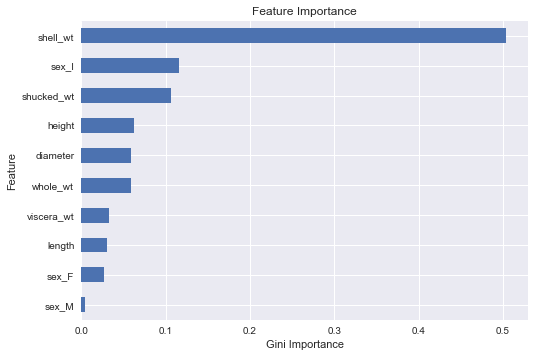

In [350]:
# Extract importances from model
importances = model.feature_importances_

# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [351]:
# Use new important features to fit the model
features = ['shucked_wt','shell_wt']
X_train, X_test,X_val, y_train, y_test, y_val =split(df,['shucked_wt','shell_wt'])

# Scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [352]:
predict(model, X_val, y_val)

1.5177119544446913

The model performs better when fitted with the two features: **shucked_wt**,  and **shell_wt**

# Communicate Results

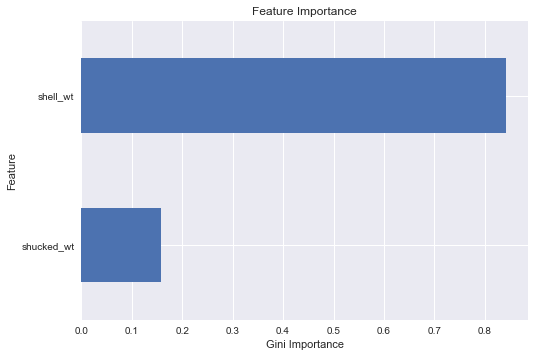

In [353]:
# Extract importances from model
importances = model.feature_importances_

# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot
feat_imp.tail(2).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [354]:
# Save model
with open("model-abalone-age.pkl", "wb")as file:
    pickle.dump(model, file)

In [355]:
X_test = scaler.transform(X_test)
predictions = model.predict(X_test)
predictions = pd.Series(predictions, index=y_test.index, name="Predictions")
df_results = pd.DataFrame(data={"actual": y_test, "prediction": predictions})

df_results[:10]

,actual,prediction
866,10.5,13.616326
1483,9.5,11.706220
599,17.5,14.160778
1702,10.5,12.051861
670,15.5,13.391311
2430,12.5,12.717700
1590,8.5,12.031348
949,7.5,10.382625
4026,8.5,8.421834
3668,11.5,12.171605


In [357]:
mae = mean_absolute_error(y_test, predictions)
print(mae)

1.5990746796986703


## Conclusions

1. **Shell weight**  and **shucked weight** are the most important predictors for the age of an abalone.
2. There is no significant difference between the male and female abalones. However, infant records lower weight.